In [224]:
import numpy as np
import pandas as pd
import ee
import requests
import os
import geopandas as gpd
# Initialize the Earth Engine API
ee.Initialize(project='ts-rishimnb')


In [225]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
print(bbox)

[78.00405826 16.93264351 79.04971836 17.90150706]


In [226]:
ee.Initialize()

# Define the area of interest (AOI) using coordinates
bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])  # Example coordinates

# Choose the Sentinel-2 image collection and filter by date and bounds
image_collection = ee.ImageCollection("MODIS/061/MOD11A1") \
    .filterBounds(bbox) \
    .filterDate('2024-03-16', '2024-05-30') \

img =image_collection.median()
# Specify the bands to download (e.g., true color bands B4, B3, B2)
url = img.getDownloadUrl({
    'bands': [
    "LST_Day_1km"],
    'region': bbox,
    'scale': 1000,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('modis_lst.tif', 'wb') as fd:
  fd.write(response.content)

GeoTIFF Metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 117, 'height': 109, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, 78.00071612009806,
       0.0, -0.008983152841195215, 17.903423612502063), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


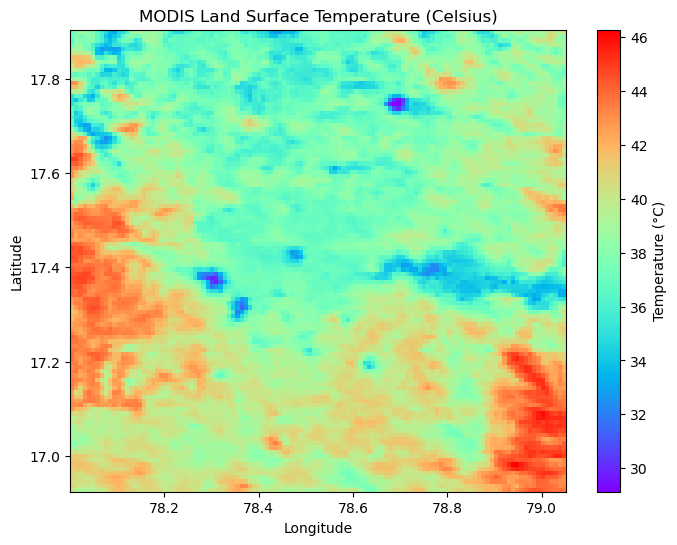

In [241]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the MODIS GeoTIFF file
geo_tiff_path = 'modis_lst.tif'  # Replace with your actual file path

with rasterio.open(geo_tiff_path) as src:
    # Read the first band (MODIS LST)
    lst_raw = src.read(1).astype(float)

    # Get metadata
    profile = src.profile
    print("GeoTIFF Metadata:")
    print(profile)

    # Get the affine transformation
    transform = src.transform
    
    # Calculate the extent of the image for plotting
    xmin, ymax = transform * (0, 0)
    xmax, ymin = transform * (lst_raw.shape[1], lst_raw.shape[0])
    extent = [xmin, xmax, ymin, ymax]

# --- 🔥 Step 1: Mask Invalid Data ---
lst_raw[lst_raw < 7500] = np.nan  # Mask fill values
lst_raw[lst_raw > 65535] = np.nan  # Ensure max value is 65535

# --- 🔥 Step 2: Apply Scale Factor ---
lst_kelvin = lst_raw * 0.02  # Convert to Kelvin

# --- 🔥 Step 3: Convert Kelvin to Celsius ---
lst_celsius = lst_kelvin - 273.15

# --- 🔥 Step 4: Plot the Scaled LST Data ---
plt.figure(figsize=(8, 6))
plt.imshow(lst_celsius, cmap='rainbow', extent=extent)  # Use 'hot' for temperature visualization
plt.title('MODIS Land Surface Temperature (Celsius)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar()
cbar.set_label('Temperature (°C)')
plt.show()


In [231]:
ee.Initialize()

# Define the area of interest (AOI) using coordinates
bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])  # Example coordinates

# Choose the Sentinel-2 image collection and filter by date and bounds
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(bbox) \
    .filterDate('2024-03-16', '2024-05-30') \

img =image_collection.median()
# Specify the bands to download (e.g., true color bands B4, B3, B2)
url = img.getDownloadUrl({
    'bands': [
    "SR_B4","SR_B5","ST_B10"],
    'region': bbox,
    'scale': 1000,
    'tiled':False,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('landsat_lst.tif', 'wb') as fd:
  fd.write(response.content)


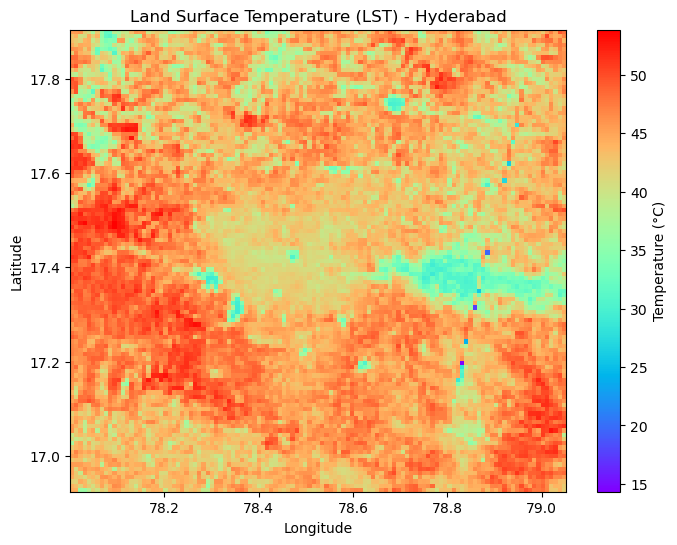

In [233]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the GeoTIFF file
geo_tiff_path = 'landsat_lst.tif'  # Replace with your file path

with rasterio.open(geo_tiff_path) as src:
    band4 = src.read(1).astype(float)  # Red Band
    band5 = src.read(2).astype(float)  # NIR Band
    band10 = src.read(3).astype(float)  # Thermal Band (ST_B10)

    # Metadata
    transform = src.transform
    extent = [transform[2], transform[2] + transform[0] * src.width,
              transform[5] + transform[4] * src.height, transform[5]]

    LST_K=band10*0.00341802+149
    LST_C=LST_K-273.15
    plt.figure(figsize=(8, 6))
    plt.imshow(LST_C, cmap='rainbow', extent=extent)  # Hot colormap for temperature
    plt.title("Land Surface Temperature (LST) - Hyderabad")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cbar = plt.colorbar()
    cbar.set_label("Temperature (°C)")
    plt.show()

In [234]:
LST_C

array([[45.35986586, 45.54102092, 45.95801936, ..., 44.74804028,
        49.5195962 , 48.28569098],
       [42.98775998, 44.1020345 , 40.36272062, ..., 44.40282026,
        44.74462226, 46.8877208 ],
       [43.11422672, 42.13325498, 41.15228324, ..., 45.11376842,
        47.53030856, 43.5893315 ],
       ...,
       [41.81537912, 41.54193752, 44.43016442, ..., 44.82323672,
        43.38937733, 43.06295642],
       [44.11228856, 43.06979246, 41.38129058, ..., 43.91575241,
        43.79270369, 42.18452528],
       [44.5805573 , 44.28660758, 36.36705524, ..., 42.4955651 ,
        44.01145697, 41.90082962]])

In [242]:
np.max(LST_C)

53.84339150000005

In [243]:
np.max(lst_celsius)

46.27000000000004

In [244]:
np.min(LST_C)

14.331080300000053

In [245]:
np.min(lst_celsius)

29.130000000000052

In [247]:
from scipy.stats import spearmanr,pearsonr
x=np.reshape(LST_C,(-1,))
x.shape
y=np.reshape(lst_celsius,(-1,))
y.shape
ans,p=pearsonr(x,y)
p

0.0

In [221]:
import numpy as np

x = np.array([1, 2, np.nan, 4, np.nan, 6])

# Corrected loop to check for NaN values
for ele in x:
    if np.isnan(ele):  # Correct way to check for NaN
        print(ele)  # Prints only NaN values


nan
nan


In [199]:
print(np.nanmin(ndvi))
print(np.nanmax(ndvi))

-0.04731281580156178
0.36122778675282713


In [200]:
print(ndvi)

[[0.18558952 0.17088802 0.14222954 ... 0.19177939 0.1518362  0.15265732]
 [0.19898293 0.18205575 0.19119947 ... 0.18436056 0.17836486 0.15152495]
 [0.18736278 0.17137725 0.17706997 ... 0.17669054 0.15791463 0.17878396]
 ...
 [0.15198115 0.14662158 0.14158431 ... 0.15410123 0.17075128 0.15304579]
 [0.1463294  0.14474145 0.13867574 ... 0.15336323 0.15690075 0.15724206]
 [0.13633014 0.14082775 0.16446171 ... 0.14586952 0.15230346 0.13702696]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


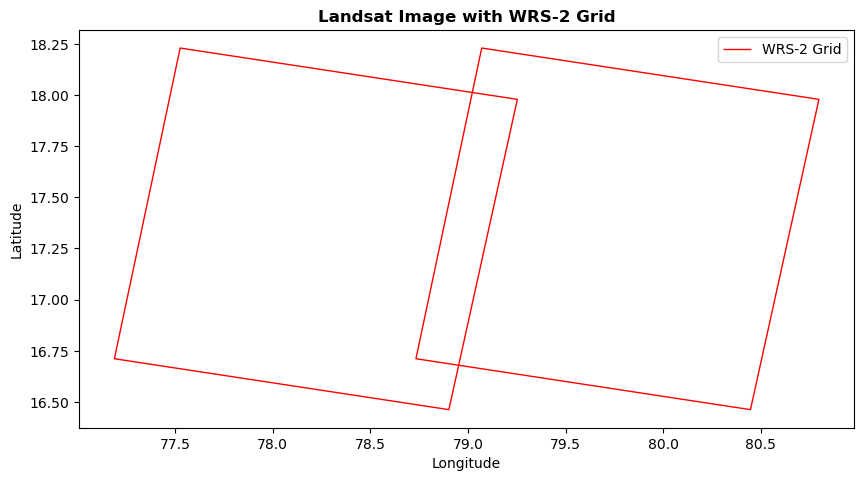

In [201]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

# File paths
shapefile_path = r"C:\Users\rishi\ml_projects\UHI\WRS2_descending_0\WRS2_descending.shp"  # Path to the WRS-2 shapefile
raster_path = "landsat_lst.tif"  # Path to your downloaded Landsat image

# Step 1: Load the shapefile
grid = gpd.read_file(shapefile_path)

# Step 2: Filter the shapefile to match the raster's bounding box
with rasterio.open(raster_path) as raster:
    raster_bounds = raster.bounds  # Get raster bounding box
    raster_crs = raster.crs       # Get raster CRS

# Ensure the shapefile and raster have the same CRS
grid = grid.to_crs(raster_crs.to_string())  # Reproject shapefile to raster CRS

# Clip the grid to the raster's bounds
clipped_grid = grid.cx[raster_bounds.left:raster_bounds.right, raster_bounds.bottom:raster_bounds.top]

# Step 3: Plot the raster and overlay the grid
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster
with rasterio.open(raster_path) as raster:
    show(raster, ax=ax, title="Landsat Image with WRS-2 Grid")

# Overlay the clipped grid
clipped_grid.boundary.plot(ax=ax, color='red', linewidth=1, label="WRS-2 Grid")

# Add labels and legend
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()
